# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import pdfo
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import statsmodels.api as sm
LOWESS = sm.nonparametric.lowess
import eofs
import xrft
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import warnings

import pyarrow as pa
import pyarrow.parquet as pq

from IPython.display import display, clear_output

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from fair import *

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=False,lon=False):
    if not lon is False:
        ax.set_xticks(lon, crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if not lat is False:
        ax.set_yticks(lat, crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Define functions

In [3]:
## function for hacking seaborn's catplot to make it pretty

def hack_catplot_range(x,y,hue,ci=66,dodge=False,hue_order=False,palette=False,**kwargs):
    
    x = x.astype(str)
    
    # calculate desired quantiles
    quantiles = [0.5-ci/200 , 0.5+ci/200]
    
    # calculate x data
    plot_x = dict(zip(x.unique(),np.arange(x.unique().size)))
    
    # if hue order
    if not hue_order:
        hue_order = hue.unique().tolist()
    
    hue_number = len(hue_order)
    
    # if dodge
    if dodge:
        plot_x_dodge = dict(zip(hue_order,np.linspace(-dodge/2,dodge/2,hue_number)))
    else:
        plot_x_dodge = dict(zip(hue.unique(),np.zeros(hue_number)))
    
    # groupby x,hue and plot
    for i,((x_level,hue_level),gr) in enumerate(y.groupby([x,hue])):
        
        if palette:
            kwargs['color'] = palette[hue_order.index(hue_level)]
        
        _y = np.nanquantile(gr.values,quantiles,interpolation='nearest')
        ## replace infs
        _y = np.where(np.isinf(_y),999999,_y)
        
        _x = plot_x[x_level] + plot_x_dodge[hue_level]
        
        plt.vlines(_x,*_y,lw=matplotlib.rcParams['lines.linewidth']*1.8,**kwargs)

In [4]:
palette = get_palette.IBM_color_blind().to_sn_palette()
## textwidth of Thesis
textwidth = 5.848611111111111

# Retrieve data

Get Anthropogenic Warming Index.

In [5]:
## HadCRUT5
HC5 = xr.open_dataset('./ancil/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')
HC5 = HC5.tas_mean.to_pandas()
HC5.index = HC5.index.year

## ERF components from AR6
erf_ar6 = pd.read_csv('./ancil/AR6_ERF_1750-2019.csv',index_col=0)

## ant / nat FaIR run
fair_erf = pd.DataFrame(index=erf_ar6.index,columns=pd.MultiIndex.from_product([['ant','aer','nat'],['forcing']]),data=pd.concat([erf_ar6.loc[:,'total_anthropogenic']-erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'total_natural']],axis=1).values)
fair_emms = return_empty_emissions(start_year=1750,end_year=2019,scen_names=['ant','aer','nat'])
fair_temps = run_FaIR(emissions_in=fair_emms,forcing_in=fair_erf)['T'].loc[1850:]

## regress HadCRUT5 onto FaIR temperature output & define anthropogenic warming index
X = np.column_stack([np.ones(fair_temps.index.size),fair_temps])
Y = HC5.loc[1850:2019].values[:,None]
mlr = OLSE.multiple(Y)
mlr.fit(X)
AWI = ( mlr.B[1]*fair_temps.aer + mlr.B[2]*fair_temps.ant ).default

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 269/269 [00:00<00:00, 2390.79 timestep/s]


## Fields

Get E-Obs observations.

In [6]:
def preproc_eobs(ds):
    
    metric = ds.encoding['source'].split('/')[-1].split('_')[-1].split('.')[0]
    
    ds['time'] = ds.time.dt.year
    
    return ds.expand_dims({'metric':[metric]}).transpose('time',...)

EObs_paths = glob.glob('/home/leachl/Documents/Attribution/BAMs_2018_Europe_summer/Obsv_return/E_Obs_0.25deg_TX*av.nc')
EObs = xr.open_mfdataset(EObs_paths,combine='nested',concat_dim=['metric'],preprocess=preproc_eobs)

## remove unwanted metrics
EObs = EObs.sel(metric=['TX10av','TX1av','TX90av'])

In [7]:
## land-sea mask
EObs['lsm'] = (EObs.isnull().sum(['time','metric'])==0).tg

Get HadGEM3A simulations.

In [8]:
def preproc_hadgem(ds):
    
    metric = ds.encoding['source'].split('/')[-2]
    
    ds = ds.assign_coords(record=np.arange(ds.record.size))
    
    ds['time'] = ds.time.dt.year
    
    ds['tas'] = ds.tas-273.15
    
    return ds.expand_dims({'metric':[metric]}).transpose('time',...)

NAT = xr.open_mfdataset(glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/NAT/TMEAN/ALL/TX*av/MERGED.nc'),preprocess=preproc_hadgem,combine='nested',concat_dim=['metric']).sel(time=2018).load()
ACT = xr.open_mfdataset(glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/ACT/TMEAN/ALL/TX*av/MERGED.nc'),preprocess=preproc_hadgem,combine='nested',concat_dim=['metric']).sel(time=2018).load()
CLIM = xr.open_mfdataset(glob.glob('/media/leachl/TOSHIBA EXT/Nicks_Documents/Attribution_data/soge-home/users/linc3691/HadGEM3A/clim/TMEAN/ALL/TX*av/MERGED.nc'),preprocess=preproc_hadgem,combine='nested',concat_dim=['metric']).load()

## replace the missing ACT member with the ensemble average
ACT['tas'][-1,-1] = ACT.tas.sel(metric='TX90av').mean('record').values

In [9]:
## add 15 members of ACT to CLIM (per E-Obs)
CLIM = xr.concat([CLIM,ACT.isel(record=np.random.choice(525,15)).assign_coords(record=np.arange(15))],dim='time')

# Analysis - fields

## Observed return time
Here we will estimate the return time of the event based on the E-Obs observations.

### detrend

In [10]:
## detrend observations using AWI
slr = OLSE.simple(EObs.tg.values)
slr.fit(AWI.loc[EObs.time.values].values[:,None,None,None])

### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
EObs['tg_trend'] = (['metric','latitude','longitude'],slr.b1)
EObs['tg_dt'] = EObs.tg - (slr.pred() - slr.pred(AWI.loc[2018]))

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

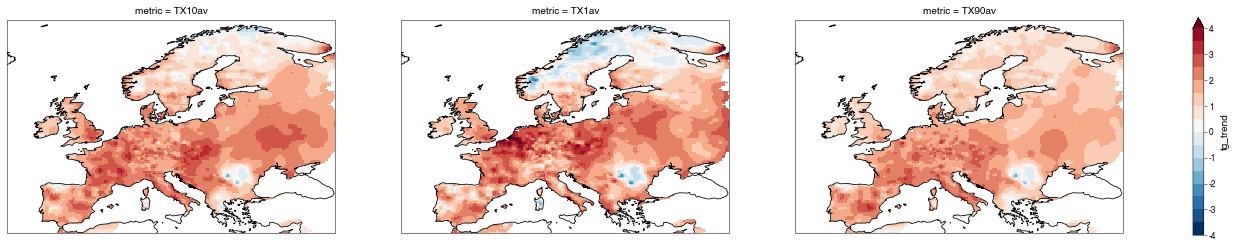

In [11]:
p = EObs.where(EObs.lsm).tg_trend.plot(figsize=(25,4),col='metric',cmap='RdBu_r',levels=np.linspace(-4,4,17),subplot_kws=dict(projection=crs.PlateCarree()),transform=crs.PlateCarree())

[a.set_extent([-15, 42, 35,72], crs=crs.PlateCarree()) for a in p.axes.flatten()]
[a.coastlines() for a in p.axes.flatten()]

''

### EVT

In [12]:
## fit GEV distributions to the detrended data
gev = LMoments.gev()
gev.fit(EObs.tg_dt.values)

RP = 1/(1-gev.cdf(EObs.tg.sel(time=2018).values))

EObs['RP'] = (['metric','latitude','longitude'], RP)

## repeat with GLO for TX90av
glo = LMoments.glo()
glo.fit(EObs.tg_dt.sel(metric='TX90av').values)

EObs['RP'][-1] = 1/(1-glo.cdf(EObs.tg.sel(metric='TX90av',time=2018).values))

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

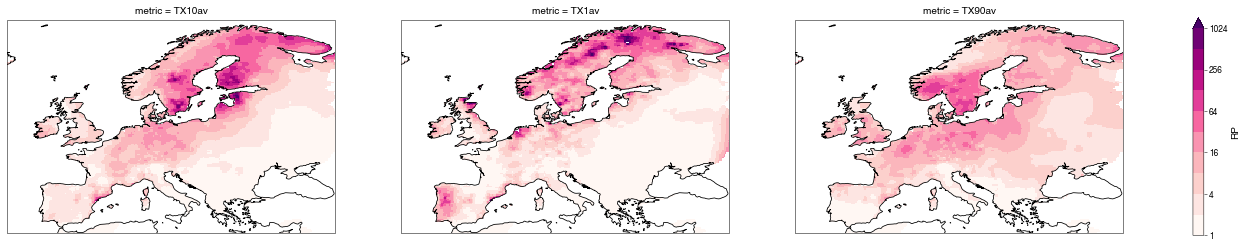

In [13]:
p = EObs.where(EObs.lsm).RP.plot(figsize=(25,4),col='metric',cmap='RdPu',levels=2**np.linspace(0,10,11),subplot_kws=dict(projection=crs.PlateCarree()),transform=crs.PlateCarree())

[a.set_extent([-15, 42, 35,72], crs=crs.PlateCarree()) for a in p.axes.flatten()]
[a.coastlines() for a in p.axes.flatten()]
p.cbar.ax.set_yticklabels((2**np.linspace(0,10,11)).astype(int))

''

## Climatological threshold

### detrend

In [14]:
## detrend climatology using AWI (averaging over ensemble members)
slr = OLSE.simple(CLIM.tas.mean('record').values)
slr.fit(AWI.loc[CLIM.time.values].values[:,None,None,None])

### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
CLIM['tas_trend'] = (['metric','latitude','longitude'],slr.b1)
CLIM['tas_dt'] = CLIM.tas - (slr.pred() - slr.pred(AWI.loc[2018]))[:,:,None,...]

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

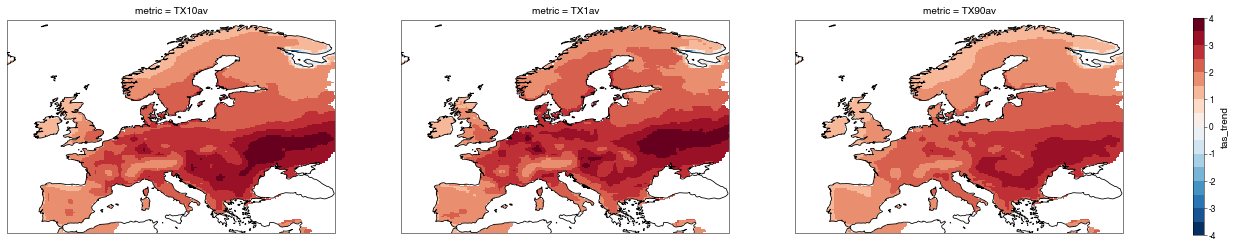

In [15]:
p = CLIM.where(EObs.lsm).tas_trend.plot(figsize=(25,4),col='metric',cmap='RdBu_r',levels=np.linspace(-4,4,17),subplot_kws=dict(projection=crs.PlateCarree()),transform=crs.PlateCarree())

[a.set_extent([-15, 42, 35,72], crs=crs.PlateCarree()) for a in p.axes.flatten()]
[a.coastlines() for a in p.axes.flatten()]

''

### EVT

In [16]:
## fit GEV distributions to the detrended data
gev = LMoments.gev()
gev.fit(CLIM.tas_dt.stack(idx=['time','record']).transpose('idx',...).values)

threshold = gev.qf(1-1/EObs.RP.values)

CLIM['tas_threshold'] = (['metric','latitude','longitude'], threshold)

## repeat with GLO for TX90av
glo = LMoments.glo()
glo.fit(CLIM.tas_dt.sel(metric='TX90av').stack(idx=['time','record']).transpose('idx',...).values)

CLIM['tas_threshold'][-1] = glo.qf(1-1/EObs.RP.sel(metric='TX90av').values)

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:260: RuntimeWarning: divide by zero encountered in power
  qf = self.X+self.a*(1-(-np.log(F))**self.k)/self.k
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:444: RuntimeWarning: divide by zero encountered in power
  qf = self.X+self.a*(1-((1-F)/F)**self.k)/self.k


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

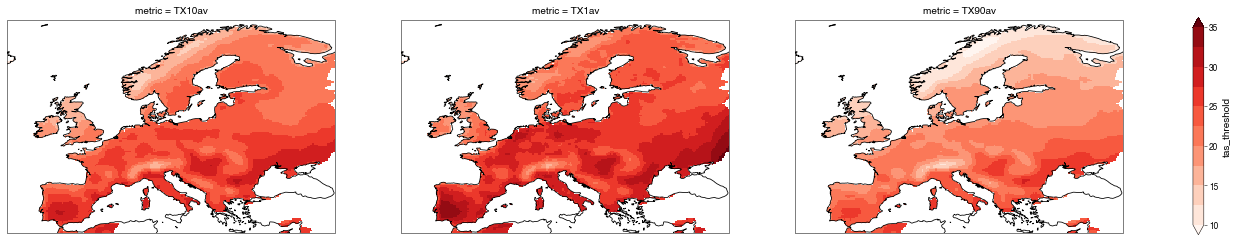

In [17]:
p = CLIM.where(EObs.lsm).tas_threshold.plot(figsize=(25,4),col='metric',cmap='Reds',levels=np.linspace(10,35,11),subplot_kws=dict(projection=crs.PlateCarree()),transform=crs.PlateCarree())

[a.set_extent([-15, 42, 35,72], crs=crs.PlateCarree()) for a in p.axes.flatten()]
[a.coastlines() for a in p.axes.flatten()]

''

## Probability ratios

### EVT

In [18]:
## ACT
ACT_gev = LMoments.gev()
ACT_gev.fit(ACT.tas.transpose('record',...).values)
ACT_RP = 1/(1-ACT_gev.cdf(CLIM.tas_threshold.values))
ACT['RP'] = (['metric','latitude','longitude'],ACT_RP)

## NAT
NAT_gev = LMoments.gev()
NAT_gev.fit(NAT.tas.transpose('record',...).values)
NAT_RP = 1/(1-NAT_gev.cdf(CLIM.tas_threshold.values))
NAT['RP'] = (['metric','latitude','longitude'],NAT_RP)

## Repeat with GLO for TX90av
### ACT
ACT_glo = LMoments.glo()
ACT_glo.fit(ACT.tas.sel(metric='TX90av').transpose('record',...).values)
ACT_RP = 1/(1-ACT_glo.cdf(CLIM.tas_threshold.sel(metric='TX90av').values))
ACT['RP'][-1] = ACT_RP
### NAT
NAT_glo = LMoments.glo()
NAT_glo.fit(NAT.tas.sel(metric='TX90av').transpose('record',...).values)
NAT_RP = 1/(1-NAT_glo.cdf(CLIM.tas_threshold.sel(metric='TX90av').values))
NAT['RP'][-1] = NAT_RP

/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:425: RuntimeWarning: invalid value encountered in power
  cdf = 1/( 1 + (1-self.k*(x-self.X)/self.a)**(1/self.k) )
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/leachl/Documents/scripts/mystatsfunctions/mystatsfunctions/LMoments.py:462: RuntimeWarning: invalid value 

# Risk ratio plot

In [19]:
# definition to rename metrics to conform to standards
rename_metrics = lambda x: 'TM'+x[2:-2]+'x'

''

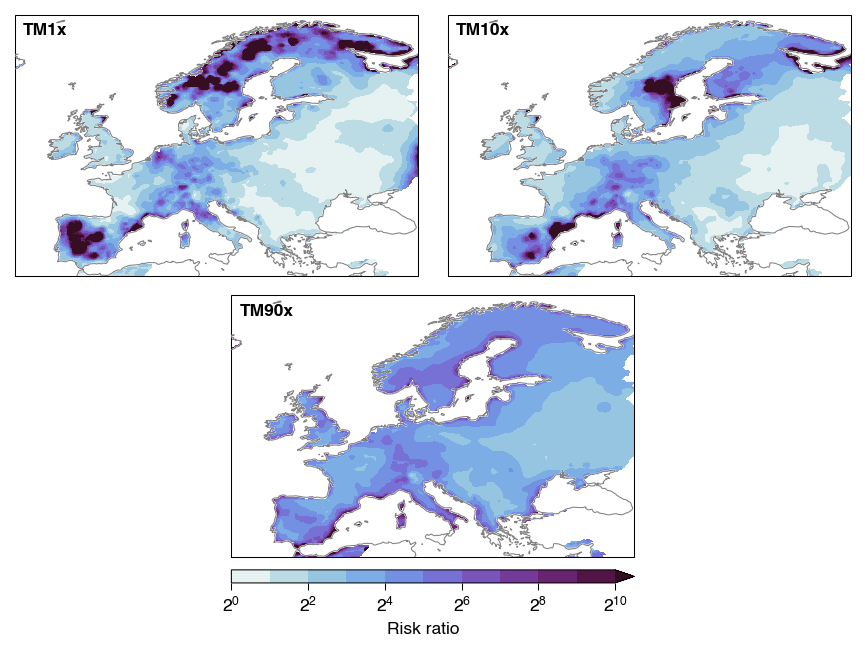

In [20]:
## set cmap
cmap = palettable.cmocean.sequential.Dense_20.get_mpl_colormap()

fig = plt.figure()
gs = fig.add_gridspec(2,4,wspace=0.1,hspace=0.1)
ax = [fig.add_subplot(gs[0,:2],projection=crs.PlateCarree()),fig.add_subplot(gs[0,2:],projection=crs.PlateCarree()),fig.add_subplot(gs[1,1:3],projection=crs.PlateCarree())]

for i,metric in enumerate(['TX1av','TX10av','TX90av']):
    
    # plot maximum daily temp anomaly
    p=(NAT.RP/ACT.RP).where(NAT.RP!=np.inf,1e6).sel(metric=metric).where(EObs.lsm).plot.contourf(ax=ax[i],cmap=cmap,extend='max',levels=2**np.linspace(0,10,11),transform=crs.PlateCarree(),add_colorbar=False)
#     p=ax[i].pcolormesh(EObs.longitude,EObs.latitude,(NAT.RP/ACT.RP).where(NAT.RP!=np.inf,1e6).sel(metric=metric).where(EObs.lsm),cmap=cmap,transform=crs.PlateCarree())
    
    ax[i].set_title('')
    ax[i].add_feature(cfeature.OCEAN,color='white',zorder=2)
    ax[i].coastlines('50m',color='grey',zorder=3,lw=0.5)
    ax[i].set_extent([-15, 42, 35,72], crs=crs.PlateCarree())
    ax[i].text(0.02,0.97,rename_metrics(metric),transform=ax[i].transAxes,va='top',ha='left',fontweight='bold',fontsize='small')

# colorbar
axins = ax[-1].inset_axes([0,-0.1,1,0.05],transform=ax[-1].transAxes)
cbar=plt.colorbar(p,cax=axins,extend='max',orientation='horizontal')
cbar.set_label('Risk ratio',fontsize='small')
cbar.ax.xaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext(2,labelOnlyBase=False))
cbar.ax.tick_params(axis='both',labelsize='small')

# fig layout
fig_aspect = 3/4
fig.patch.set_facecolor('xkcd:white')
fig.set_size_inches(textwidth,textwidth*fig_aspect)
fig.dpi=150
gs.tight_layout(fig,pad=1)

## save to Thesis directory
[fig.savefig('/home/leachl/Documents/Thesis/Ch1/Figures/Fig1.4.'+x, dpi=600) for x in ['pdf','png']]
''